# Summary

This is a NLP sentiment analysis project that is predicting on the star rating a customer will give based on their Amazon product review. My stakeholder is Amazon and any company that sells their product on Amazon.com. This sentiment analysis can helps companies imporve their future or current products and imporve customer satisfaction with their products. I got this dataset from Amazon Web Services(AWS) and I only got wireless product reviews because the qireless products already have pver 8 million reviews. The dataset has 15 columns and I am predicting on the star rating column which goes from 1 star to 5 stars. I started out by getting rid of null and unnecessary values, fixing the class imbalance, and sampling 10,000 reviews out of the 8 million reviews. Once a I did the preprocessing I had to prepare the data for modeling by using word tokenization, dropping stopwords, lowercasing all text, stemming the texts, and using TFIDF vectorizer to get the importance of words. After all that I started to create models for classification. I started out with a base logistic regression model and it gave a good precision score of 79% which ended up being the best model. After that I started creating models for KNN, XGB, and random forest but the these models were not able to get a better precision score than the base logistic regression model. SMOTE did not fix the class imbalance so I used over sampler instead. I recommend using the base logistic regression model, but would not recommend using it to predict the negative and neutral reviews.


In [107]:
# Importing packages
import pandas as pd
import seaborn as sns
import random
import itertools
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.metrics._plot.confusion_matrix import confusion_matrix
from imblearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk import pos_tag
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem import SnowballStemmer
import matplotlib.pyplot as plt
import string
import re
import numpy as np
from imblearn.over_sampling import RandomOverSampler

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# Getting data from google drive
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab_Notebooks

Mounted at /content/drive
/content/drive/MyDrive/Colab_Notebooks


In [4]:
# Loading the data as df and skipped the unreadable lines
df = pd.read_csv('wireless.tsv', sep='\t', error_bad_lines=False)

b'Skipping line 51163: expected 15 fields, saw 22\n'
b'Skipping line 77018: expected 15 fields, saw 22\nSkipping line 97528: expected 15 fields, saw 22\n'
b'Skipping line 145503: expected 15 fields, saw 22\nSkipping line 172172: expected 15 fields, saw 22\nSkipping line 185136: expected 15 fields, saw 22\nSkipping line 187592: expected 15 fields, saw 22\n'
b'Skipping line 222158: expected 15 fields, saw 22\nSkipping line 232048: expected 15 fields, saw 22\nSkipping line 232320: expected 15 fields, saw 22\nSkipping line 234653: expected 15 fields, saw 22\nSkipping line 257210: expected 15 fields, saw 22\nSkipping line 261368: expected 15 fields, saw 22\n'
b'Skipping line 262843: expected 15 fields, saw 22\nSkipping line 274082: expected 15 fields, saw 22\nSkipping line 276172: expected 15 fields, saw 22\nSkipping line 327076: expected 15 fields, saw 22\n'
b'Skipping line 328675: expected 15 fields, saw 22\nSkipping line 366744: expected 15 fields, saw 22\nSkipping line 380897: expected 

In [5]:
# Checking how many rows are in the data
len(df)

8991589

In [6]:
# Loading the data
df

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,16414143,R3W4P9UBGNGH1U,B00YL0EKWE,852431543,LG G4 Case Hard Transparent Slim Clear Cover f...,Wireless,2,1.0,3.0,N,Y,"Looks good, functions meh",2 issues - Once I turned on the circle apps ...,2015-08-31
1,US,50800750,R15V54KBMTQWAY,B00XK95RPQ,516894650,Selfie Stick Fiblastiq&trade; Extendable Wirel...,Wireless,4,0.0,0.0,N,N,A fun little gadget,"I’m embarrassed to admit that until recently, ...",2015-08-31
2,US,15184378,RY8I449HNXSVF,B00SXRXUKO,984297154,Tribe AB40 Water Resistant Sports Armband with...,Wireless,5,0.0,0.0,N,Y,Five Stars,Fits iPhone 6 well,2015-08-31
3,US,10203548,R18TLJYCKJFLSR,B009V5X1CE,279912704,RAVPower® Element 10400mAh External Battery US...,Wireless,5,0.0,0.0,N,Y,Great charger,Great charger. I easily get 3+ charges on a S...,2015-08-31
4,US,488280,R1NK26SWS53B8Q,B00D93OVF0,662791300,Fosmon Micro USB Value Pack Bundle for Samsung...,Wireless,5,0.0,0.0,N,Y,Five Stars,Great for the price :-),2015-08-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8991584,US,51706541,R3ZKCWKG4097P,B00000J40U,91541241,Garmin GPS III Waterproof Hiking GPS,Wireless,4,12.0,12.0,N,N,When you really need to know.,We train search and rescue dogs in Colorado an...,1999-07-13
8991585,US,51660758,R2D0X18EHNKEOJ,B00000JBRT,226432064,Uniden BC245XLT Handheld Scanner,Wireless,5,10.0,13.0,N,N,A must have for trunked radio systems,I have had the BC245XLT for almost a week now....,1999-07-13
8991586,US,53076522,R292SJRN80H8OQ,B00000DM9D,730627849,Garmin GPS II Plus Waterproof Hiking GPS,Wireless,4,1.0,6.0,N,N,Better suit for US market,I brought my Gramin GPS II last month. The fe...,1999-01-03
8991587,US,52780824,R3HA5IXDCVJ65K,B00000DM9D,730627849,Garmin GPS II Plus Waterproof Hiking GPS,Wireless,5,24.0,25.0,N,N,"A rugged, spectacular essential for wilderness...","I made a 4 day, 3 night solo hike in Big Bend ...",1998-12-26


## Preprocessing
  - Getting rid of null values
  - Getting rid unnessecary rows
  - Sampling of 10,000 random rows

In [ ]:
# Looking at the value counts in the product category column
# Need only the 'wireless' values
df['product_category'].value_counts()

Wireless      8991479
2009-03-23          2
2010-04-07          2
2010-03-20          2
2010-09-08          2
               ...   
2011-05-23          1
2011-05-25          1
2011-06-20          1
2011-07-28          1
2008-11-18          1
Name: product_category, Length: 103, dtype: int64

In [ ]:
# Looking at the dtype of the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8991589 entries, 0 to 8991588
Data columns (total 15 columns):
 #   Column             Dtype  
---  ------             -----  
 0   marketplace        object 
 1   customer_id        int64  
 2   review_id          object 
 3   product_id         object 
 4   product_parent     int64  
 5   product_title      object 
 6   product_category   object 
 7   star_rating        object 
 8   helpful_votes      float64
 9   total_votes        float64
 10  vine               object 
 11  verified_purchase  object 
 12  review_headline    object 
 13  review_body        object 
 14  review_date        object 
dtypes: float64(2), int64(2), object(11)
memory usage: 1.0+ GB


In [7]:
# Only including the 'wireless' values for the product_category column
df = df[df['product_category'].str.contains('Wireless')]

In [ ]:
# Looking for null values
df.isna().sum()

marketplace            0
customer_id            0
review_id              0
product_id             0
product_parent         0
product_title          0
product_category       0
star_rating            0
helpful_votes          0
total_votes            0
vine                   0
verified_purchase      0
review_headline       90
review_body          538
review_date           41
dtype: int64

In [9]:
# Dropped all null values
df.dropna(subset = ['review_body'], inplace=True)
df.dropna(subset = ['review_headline'], inplace=True)
df.dropna(subset = ['review_date'], inplace=True)

In [12]:
# Sampled 10,000 values at random
onemill_df = df.sample(10000, random_state=42)
onemill_df

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
3459164,US,45111270,R24Y40PFGXPABC,B00H7KO4LM,320593273,Gym Workout Sports Armband Strap for Apple iPo...,Wireless,5,0.0,0.0,N,Y,Five Stars,great price...but band wears out and loses it ...,2014-11-21
5188743,US,21553839,R176X2J5LVA396,B003ZBZ64Q,355647540,"External Battery, New Trent iCarrier 12000mAh ...",Wireless,5,0.0,0.0,N,N,Great portable power!,I bought this product specifically for a week ...,2014-04-17
3320459,US,34618560,R3E4Q4EGG64G2Z,B00MAWQPJQ,481664990,"Galaxy Note 4 Case, Slim Armor Case for Note 4",Wireless,5,0.0,0.0,N,Y,Tough armor is not so great. This case is better,This one fits very well and has suffered a few...,2014-12-04
5836236,US,10631348,R1K14I596V0ZBW,B00CZ151K6,953952518,Doctor Who Tardis Police Box Hard Snap on Case...,Wireless,5,0.0,0.0,N,Y,Amazing,I am a huge fan of the show and this is one of...,2013-12-30
3670429,US,39526799,R2T0PNYJNK20OR,B00JH88GB6,742767901,Spigen Slim Armor iPhone 6 Case with Air Cushi...,Wireless,5,0.0,0.0,N,Y,Five Stars,Everything fine,2014-10-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7952753,US,35143498,R2N6AM022CSIXF,B007IP3KKC,737702804,LG Lucid 4G (Verizon) Premium Combo Pack - Wal...,Wireless,4,1.0,1.0,N,Y,Lucid chargers,perfect package at very reasonable price. ini...,2012-08-17
5244670,US,2813891,RK4LBFHJ04F1D,B00GPD935E,400002023,Generic iPhone 5C Armor Slim Case Heavy Duty C...,Wireless,5,0.0,0.0,N,Y,iPhone case,The iPhone case is really cool and the picture...,2014-04-06
1183774,US,25003818,R2VRPGXUX1KIF1,B00SXNVXPM,896926468,"Car Mount, Ramkon Magnetic Universal Air Vent ...",Wireless,5,0.0,0.0,N,N,Nice addition to my car,Great cell phone holder I was really surprised...,2015-05-25
6999396,US,12816711,R2EIMVR5T53K9C,B007K6DTUU,770777604,Amzer AMZ93528 Shellster Case Cover for Apple ...,Wireless,4.0,1.0,1.0,N,Y,Great fit and slim too,Fits the Ipod touch great and is a versatile h...,2013-04-29


In [13]:
# Checking the stop words
stop_words = stopwords.words('english')
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [15]:
# Coverting the star_rating column from an object to an integer
onemill_df['star_rating'] = onemill_df['star_rating'].astype(int)

<Axes: xlabel='star_rating', ylabel='count'>

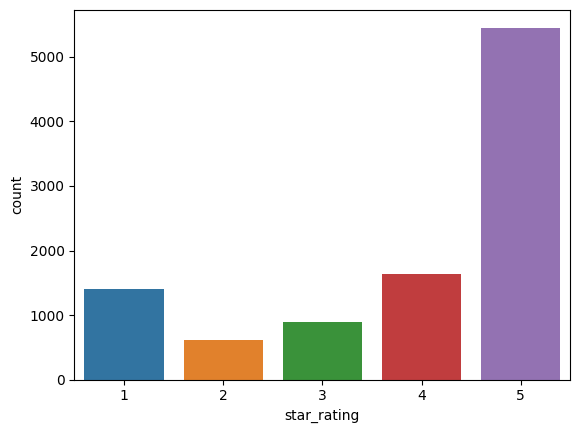

In [17]:
# Checking the counts of ech value in the star_rating column
# Seems to be a class imbalance
sns.countplot(x='star_rating', data=onemill_df)

## Preparation
  - Word tokenization
  - Getting rid of stopwords
  - Lowercasing all text
  - Snowball stemmer
  - TFIDF Vectorization 

In [18]:
# Splitting all the sentences into words in the reviews
corpus = [word_tokenize(text) for text in onemill_df['review_body']]

In [19]:
# Getting the first review split up
print(corpus[0])

['great', 'price', '...', 'but', 'band', 'wears', 'out', 'and', 'loses', 'it', 'lasticity', 'very', 'easy']


In [20]:
# Flattening the tokenized words so that it can be taken in by the models
flatten_corpus = pd.Series(list(itertools.chain(*corpus)))
print(flatten_corpus.shape)
print(len(flatten_corpus.unique()))

(594418,)
20912


In [21]:
# Checking the most common words or symbols
# We need to get rid of these periods an commas
flatten_corpus.value_counts()

.                 28575
the               23845
I                 16591
,                 15369
it                13856
                  ...  
marcas                1
preferidas            1
disaster-proof        1
rubbeer               1
embarrassing          1
Length: 20912, dtype: int64

In [22]:
# Checking how many words only occur once in the whole data
# Those words are not that important so it's better tot delete them
(flatten_corpus.value_counts() == 1).sum()

10840

In [23]:
# Getting the unique values from the corpus and making them into a dicti value
dicti = pd.Series(flatten_corpus.unique())

In [24]:
# Checking for numeric values and we might need to get rid of them
dicti[dicti.str.isnumeric()]

137         6
140         4
207         3
302         2
323        34
         ... 
20426     906
20451    2400
20575     168
20595    6035
20677    3595
Length: 278, dtype: object

In [25]:
# Lower casing and getting rid of all the stop words to make the models less complex
def normalizer(doc):
    lower_text = [x.lower() for x in word_tokenize(doc) if ((x.isalpha()) & (x not in stop_words))]
    return lower_text

In [26]:
# Applying the normalizer to the dataset as a new column
onemill_df['lowercase'] = onemill_df['review_body'].apply(normalizer)
onemill_df

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,lowercase
3459164,US,45111270,R24Y40PFGXPABC,B00H7KO4LM,320593273,Gym Workout Sports Armband Strap for Apple iPo...,Wireless,5,0.0,0.0,N,Y,Five Stars,great price...but band wears out and loses it ...,2014-11-21,"[great, price, band, wears, loses, lasticity, ..."
5188743,US,21553839,R176X2J5LVA396,B003ZBZ64Q,355647540,"External Battery, New Trent iCarrier 12000mAh ...",Wireless,5,0.0,0.0,N,N,Great portable power!,I bought this product specifically for a week ...,2014-04-17,"[i, bought, product, specifically, week, long,..."
3320459,US,34618560,R3E4Q4EGG64G2Z,B00MAWQPJQ,481664990,"Galaxy Note 4 Case, Slim Armor Case for Note 4",Wireless,5,0.0,0.0,N,Y,Tough armor is not so great. This case is better,This one fits very well and has suffered a few...,2014-12-04,"[this, one, fits, well, suffered, drops, witho..."
5836236,US,10631348,R1K14I596V0ZBW,B00CZ151K6,953952518,Doctor Who Tardis Police Box Hard Snap on Case...,Wireless,5,0.0,0.0,N,Y,Amazing,I am a huge fan of the show and this is one of...,2013-12-30,"[i, huge, fan, show, one, best, things, add, e..."
3670429,US,39526799,R2T0PNYJNK20OR,B00JH88GB6,742767901,Spigen Slim Armor iPhone 6 Case with Air Cushi...,Wireless,5,0.0,0.0,N,Y,Five Stars,Everything fine,2014-10-30,"[everything, fine]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7952753,US,35143498,R2N6AM022CSIXF,B007IP3KKC,737702804,LG Lucid 4G (Verizon) Premium Combo Pack - Wal...,Wireless,4,1.0,1.0,N,Y,Lucid chargers,perfect package at very reasonable price. ini...,2012-08-17,"[perfect, package, reasonable, price, initial,..."
5244670,US,2813891,RK4LBFHJ04F1D,B00GPD935E,400002023,Generic iPhone 5C Armor Slim Case Heavy Duty C...,Wireless,5,0.0,0.0,N,Y,iPhone case,The iPhone case is really cool and the picture...,2014-04-06,"[the, iphone, case, really, cool, picture, gal..."
1183774,US,25003818,R2VRPGXUX1KIF1,B00SXNVXPM,896926468,"Car Mount, Ramkon Magnetic Universal Air Vent ...",Wireless,5,0.0,0.0,N,N,Nice addition to my car,Great cell phone holder I was really surprised...,2015-05-25,"[great, cell, phone, holder, i, really, surpri..."
6999396,US,12816711,R2EIMVR5T53K9C,B007K6DTUU,770777604,Amzer AMZ93528 Shellster Case Cover for Apple ...,Wireless,4,1.0,1.0,N,Y,Great fit and slim too,Fits the Ipod touch great and is a versatile h...,2013-04-29,"[fits, ipod, touch, great, versatile, holder, ..."


In [27]:
# Looking at the first row of the lowercase column
print(onemill_df['lowercase'].iloc[0])

['great', 'price', 'band', 'wears', 'loses', 'lasticity', 'easy']


In [28]:
# Flattening the lower column so that it can be taken in by the models
lower_flat = pd.Series(list(itertools.chain(*onemill_df['lowercase'])))
new_dict = lower_flat.unique()
print(len(new_dict))

12771


In [29]:
# There are less unique values now compared to before because it went from 20,912 unique values to 12,771 unique values
print(len(dicti))

20912


In [31]:
# Using snowball stemmer because it takes in shorter words and takes less as long compared to other stemmers and lemmatization
snow_stem = SnowballStemmer(language='english')
snow_doc = []
for index, row in onemill_df.iterrows():
    words = ' '.join(row['lowercase'])
    words = words.split()
    stemmed_words = [snow_stem.stem(word) for word in words]
    snow_doc.append(' '.join(stemmed_words))

print(snow_doc[0])

great price band wear lose lastic easi


In [32]:
# Printing the second row of the stemmed texts 
print(snow_doc[1])

i bought product specif week long trip br br i use ever br br it charg fast easi take import part travel br br would recommend anyon look portabl power


In [33]:
# Making a new column with the snow doc stemming
onemill_df['snow_doc'] = snow_doc

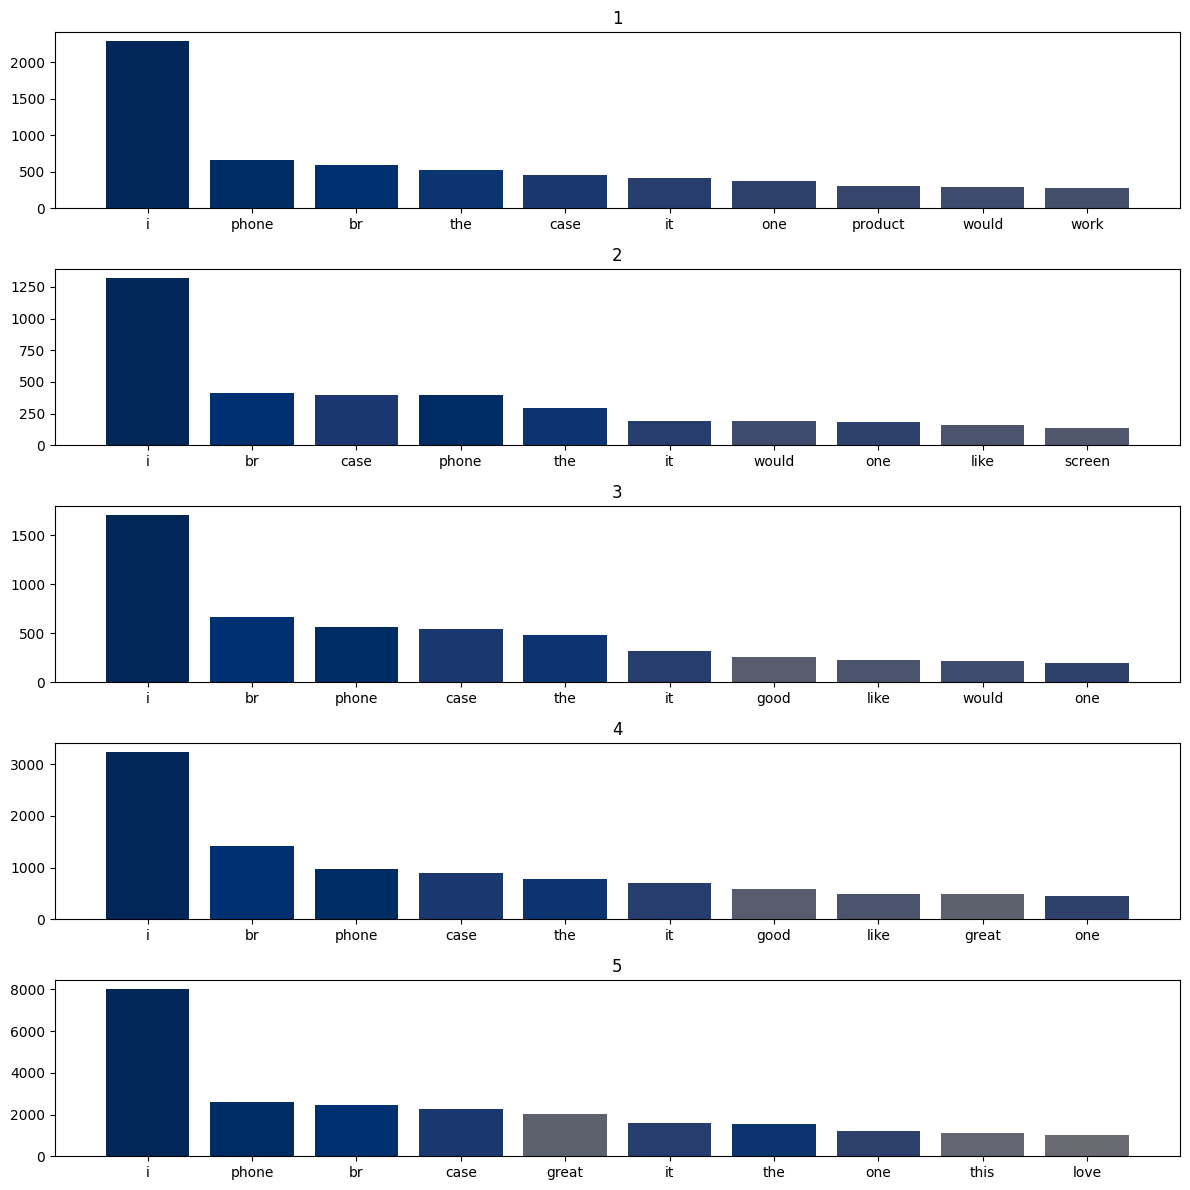

In [37]:
# Set up figure and axes
fig, axes = plt.subplots(nrows=5, figsize=(12, 12))

# Empty dict to hold words that have already been plotted and their colors
plotted_words_and_colors = {}
# Establishing color palette to pull from
# (If you get an error message about popping from an empty list, increase this #)
color_palette = sns.color_palette('cividis', n_colors=38)

# Creating a plot for each rating
data_by_rating = [y for _, y in onemill_df.groupby('star_rating', as_index=False)]
for idx, rating_df in enumerate(data_by_rating):
    # Find top 10 words in each rating
    all_words_in_rating = rating_df.lowercase.explode()
    top_10 = all_words_in_rating.value_counts()[:10]
    
    # Select appropriate colors, reusing colors if words repeat
    colors = []
    for word in top_10.index:
        if word not in plotted_words_and_colors:
            new_color = color_palette.pop(0)
            plotted_words_and_colors[word] = new_color
        colors.append(plotted_words_and_colors[word])
    
    # Select axes, plot data, set title
    ax = axes[idx]
    ax.bar(top_10.index, top_10.values, color=colors)
    ax.set_title(str(rating_df.iloc[0].star_rating).title())
    
fig.tight_layout()

In [38]:
# Lowering the classes from 5 to 3
dic = {1:0, 2:0, 3:1,4:2,5:2 }

In [39]:
# Train test splitting the with the applied dic on the y train
X = onemill_df['snow_doc']
y = onemill_df['star_rating'].astype(int).map(dic)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [40]:
# Using a tfidf vectorizer because it takes in the importance of words and not just the counts
tfid = TfidfVectorizer(min_df=0.01, max_df=1.)
X_train_tf = tfid.fit_transform(X_train)
X_test_tf = tfid.transform(X_test)
print('Vocabulary Size: ', len(tfid.get_feature_names_out()))

Vocabulary Size:  452


In [46]:
# Reshapping, over sampling, and using tfidf vectorizer for models not in pipeline
X_train_reshaped = X_train.values.reshape((-1, 1))
y_train_reshaped = y_train.values.reshape((-1, 1))
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train_reshaped, y_train_reshaped)
vect = TfidfVectorizer(min_df=0.01, max_df=1.)
X_train_flattened = np.concatenate(X_train_resampled).ravel().astype(str)
X_train_vect = vect.fit_transform(X_train_flattened)
X_test_vect = vect.transform(X_test)

## Best Model: Base Logistic Regression Model

In [47]:
# Creating base logitsic regression model and fitting it
logregbase = LogisticRegression()
logregbase.fit(X_train_vect, y_train_resampled)

LogisticRegression()

In [48]:
# Printing test and train scores
# Seems like a little overfitting
print(logregbase.score(X_test_vect, y_test))
print(logregbase.score(X_train_vect, y_train_resampled))

0.7015
0.7569077013521458


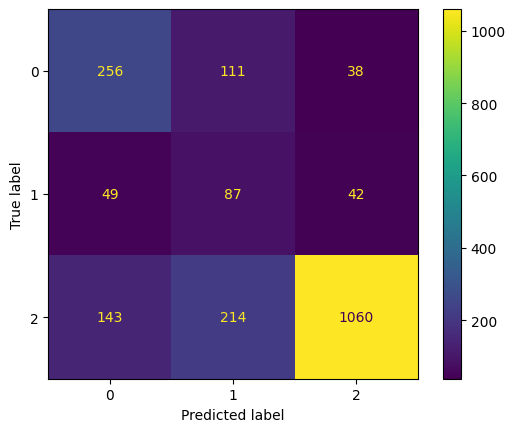

In [49]:
# Creating confusion matrix
ConfusionMatrixDisplay.from_estimator(logregbase, X_test_vect, y_test)

In [50]:
# CReating prediction and classification report for model
# Has a good precision score
# We want to check for precision because we want a good positive class prediction
y_logreg_pred = logregbase.predict(X_test_vect)

print(classification_report(y_test, y_logreg_pred))

              precision    recall  f1-score   support

           0       0.57      0.63      0.60       405
           1       0.21      0.49      0.29       178
           2       0.93      0.75      0.83      1417

    accuracy                           0.70      2000
   macro avg       0.57      0.62      0.57      2000
weighted avg       0.79      0.70      0.74      2000



## Logistic Regression model in Pipeline

In [109]:
# Logstic regression model in pipeline and stacking it
lmodels = [('logreg', LogisticRegression())]
sclog = StackingClassifier(lmodels)

In [110]:
# Fitting the pipline with SMOTE to help with class imbalance
logpl = Pipeline([('smote', SMOTE()), ('lmodel', sclog)])
logpl.fit(X_train_tf, y_train)

Pipeline(steps=[('smote', SMOTE()),
                ('lmodel',
                 StackingClassifier(estimators=[('logreg',
                                                 LogisticRegression())]))])

In [ ]:
# Score for train and test
print(logpl.score(X_test_tf, y_test))
print(logpl.score(X_train_tf, y_train))

0.693
0.74875


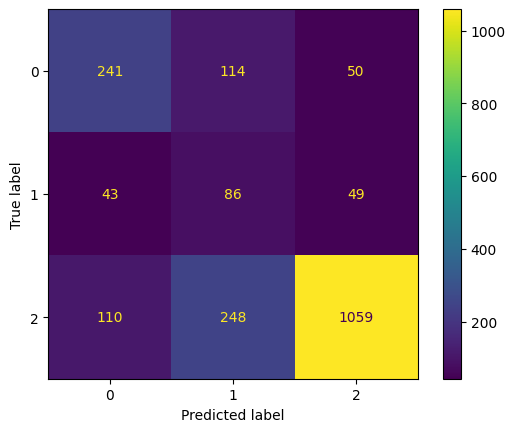

In [ ]:
# Creating confusion matrix
ConfusionMatrixDisplay.from_estimator(logpl, X_test_tf, y_test)

In [ ]:
# Predicting on the test and creating a classification report
log_pred = logpl.predict(X_test_tf)
print(classification_report(y_test, log_pred))

              precision    recall  f1-score   support

           0       0.61      0.60      0.60       405
           1       0.19      0.48      0.27       178
           2       0.91      0.75      0.82      1417

    accuracy                           0.69      2000
   macro avg       0.57      0.61      0.57      2000
weighted avg       0.79      0.69      0.73      2000



In [ ]:
# Creating a grid for C and penalty
log_grid = {'lmodel__logreg__C': [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000],
            'lmodel__logreg__penalty': ['l2']}

log_search = GridSearchCV(estimator=logpl,
                          param_grid=log_grid,
                          scoring='roc_auc',
                          cv=5,
                          n_jobs=-1)

log_search.fit(X_train_tf, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote', SMOTE()),
                                       ('lmodel',
                                        StackingClassifier(estimators=[('logreg',
                                                                        LogisticRegression())]))]),
             n_jobs=-1,
             param_grid={'lmodel__logreg__C': [0.0001, 0.001, 0.01, 0.1, 1, 10,
                                               100, 1000],
                         'lmodel__logreg__penalty': ['l2']},
             scoring='roc_auc')

In [ ]:
# Best params seem to be C at 0.0001
log_search.best_params_

{'lmodel__logreg__C': 0.0001, 'lmodel__logreg__penalty': 'l2'}

## Logistic Regression model without Pipeline

In [99]:
# Logistic Regression Model with best parameters
logreg = LogisticRegression(penalty='l2', C=0.0001)
logreg.fit(X_train_vect, y_train_resampled)

LogisticRegression(C=0.0001)

In [100]:
# Train and test scores of model
print(logreg.score(X_test_vect, y_test))
print(logreg.score(X_train_vect, y_train_resampled))

0.6355
0.6442092886537331


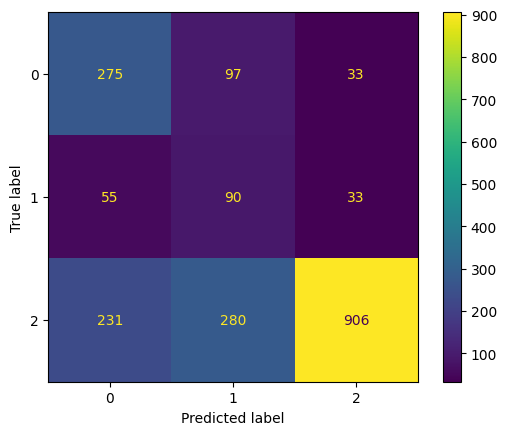

In [101]:
# Confusion matrix of model
ConfusionMatrixDisplay.from_estimator(logreg, X_test_vect, y_test)

In [102]:
# Prediction and classification report of model
# Precision is as good as the logistic regression in the pipeline
y_vect_pred = logreg.predict(X_test_vect)

print(classification_report(y_test, y_vect_pred))

              precision    recall  f1-score   support

           0       0.49      0.68      0.57       405
           1       0.19      0.51      0.28       178
           2       0.93      0.64      0.76      1417

    accuracy                           0.64      2000
   macro avg       0.54      0.61      0.54      2000
weighted avg       0.78      0.64      0.68      2000



## KNN, XGB, and Random Forest models

In [ ]:
# Fitting a KNN model with pipeline and stacking it
kmodels = [('knn1', KNeighborsClassifier())]
scknn = StackingClassifier(estimators=kmodels, final_estimator=None)
knnpl = Pipeline([('smote', SMOTE()), ('knnmodel', scknn)])
knnpl.fit(X_train_tf, y_train)

Pipeline(steps=[('smote', SMOTE()),
                ('knnmodel',
                 StackingClassifier(estimators=[('knn1',
                                                 KNeighborsClassifier())]))])

In [ ]:
# Getting the scores of the train and test
# There is overfitting
print(knnpl.score(X_test_tf, y_test))
print(knnpl.score(X_train_tf, y_train))

0.4965
0.765


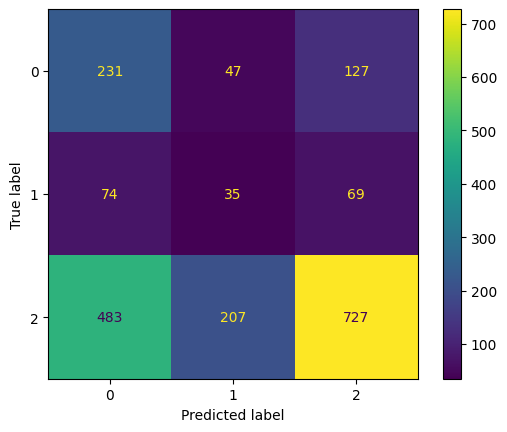

In [ ]:
# Creating a confusion matrix from pipeline
ConfusionMatrixDisplay.from_estimator(knnpl, X_test_tf, y_test)

In [ ]:
# Predicting and creating a classification report from pipeline
# Not a great precision score
knn_pred = knnpl.predict(X_test_tf)
print(classification_report(y_test, knn_pred))

              precision    recall  f1-score   support

           0       0.29      0.57      0.39       405
           1       0.12      0.20      0.15       178
           2       0.79      0.51      0.62      1417

    accuracy                           0.50      2000
   macro avg       0.40      0.43      0.39      2000
weighted avg       0.63      0.50      0.53      2000



In [ ]:
# Doing hyperparameter tuning to get a better score
knn_grid = {'knnmodel__knn1__n_neighbors': [100, 150, 200, 250, 300],
            'knnmodel__knn1__p': [1, 2, 3, 4, 5]}

knn_search = GridSearchCV(estimator=knnpl,
                          param_grid=knn_grid,
                          scoring='roc_auc',
                          cv=5,
                          n_jobs=-1)

knn_search.fit(X_train_tf, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote', SMOTE()),
                                       ('knnmodel',
                                        StackingClassifier(estimators=[('knn1',
                                                                        KNeighborsClassifier())]))]),
             n_jobs=-1,
             param_grid={'knnmodel__knn1__n_neighbors': [100, 150, 200, 250,
                                                         300],
                         'knnmodel__knn1__p': [1, 2, 3, 4, 5]},
             scoring='roc_auc')

In [ ]:
# Best params seem to be n_neighbors at 100 and p at 1
display(knn_search.best_params_)

{'knnmodel__knn1__n_neighbors': 100, 'knnmodel__knn1__p': 1}

In [ ]:
# Adding the paramters to the KNN without a pipeline
kneigh = KNeighborsClassifier(n_neighbors= 50, p=1, weights='uniform')
kneigh.fit(X_train_vect, y_train_resampled)

KNeighborsClassifier(n_neighbors=50, p=1)

In [ ]:
# Getting the test and train scores
# Has a better test score but there is still overfitting
print(kneigh.score(X_test_vect, y_test))
print(kneigh.score(X_train_vect, y_train_resampled))

0.6835
0.36854791299235745


In [ ]:
# Predicting and creating a classification report for KNN with hyperparamters
# The precision score is worse than before
y_knn1_pred = kneigh.predict(X_test_vect)
print(classification_report(y_test, y_knn1_pred))

              precision    recall  f1-score   support

           0       0.20      0.05      0.08       405
           1       0.00      0.00      0.00       178
           2       0.71      0.95      0.81      1417

    accuracy                           0.68      2000
   macro avg       0.30      0.33      0.30      2000
weighted avg       0.54      0.68      0.59      2000



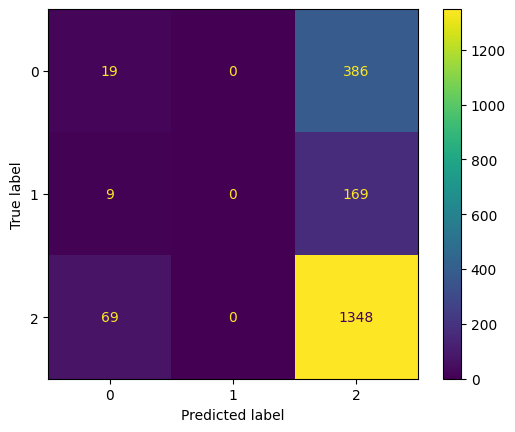

In [ ]:
# Creating a confusion matrix
ConfusionMatrixDisplay.from_estimator(kneigh, X_test_vect, y_test)

In [ ]:
# Trying to use a XGB Classifier in  a pipeline and no hyperparameters
models = [('xgbc', XGBClassifier())]
scxg = StackingClassifier(estimators=models, final_estimator=None)

In [ ]:
# Fitting pipline with SMOTE
plxg = Pipeline([('smote', SMOTE()), ('modelxg', scxg)])
plxg.fit(X_train_tf, y_train)

Pipeline(steps=[('smote', SMOTE()),
                ('modelxg',
                 StackingClassifier(estimators=[('xgbc',
                                                 XGBClassifier(base_score=None,
                                                               booster=None,
                                                               callbacks=None,
                                                               colsample_bylevel=None,
                                                               colsample_bynode=None,
                                                               colsample_bytree=None,
                                                               early_stopping_rounds=None,
                                                               enable_categorical=False,
                                                               eval_metric=None,
                                                               feature_types=None,
                                                               gamma=None,
                                                               gpu_id=None,
                                                               grow_policy=None,
                                                               importance_type=None,
                                                               interaction_constraints=None,
                                                               learning_rate=None,
                                                               max_bin=None,
                                                               max_cat_threshold=None,
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=None,
                                                               max_depth=None,
                                                               max_leaves=None,
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               n_estimators=100,
                                                               n_jobs=None,
                                                               num_parallel_tree=None,
                                                               predictor=None,
                                                               random_state=None, ...))]))])

In [ ]:
# Getting scores from train and test
# There is overfitting
print(plxg.score(X_test_tf, y_test))
print(plxg.score(X_train_tf, y_train))

0.7475
0.917375


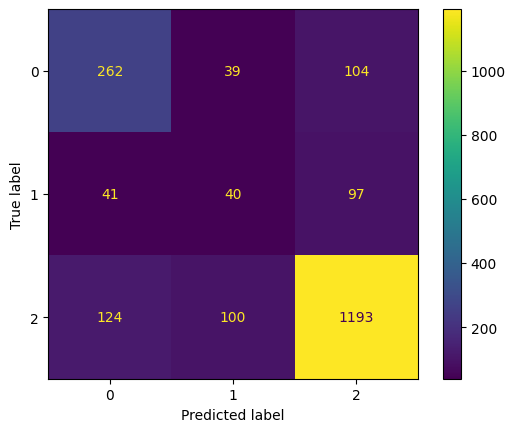

In [ ]:
# Creating a confusion matrix
ConfusionMatrixDisplay.from_estimator(plxg, X_test_tf, y_test)

In [ ]:
# Predicting and creating a classification report from model
# Not a bad precision score but not better than the best model
xgbpl_predict1 = plxg.predict(X_test_tf)
print(classification_report(y_test, xgbpl_predict1))

              precision    recall  f1-score   support

           0       0.61      0.65      0.63       405
           1       0.22      0.22      0.22       178
           2       0.86      0.84      0.85      1417

    accuracy                           0.75      2000
   macro avg       0.56      0.57      0.57      2000
weighted avg       0.75      0.75      0.75      2000



In [ ]:
# Adding hyperparmaters to XGB classifier model to imporve score and fix class imbalance
pl_grid_xgb1 = {'modelxg__xgbc__max_depth': [1, 2, 3, 4, 5],
            'modelxg__xgbc__max_leaves': [0, 1, 2, 3, 4]}

pl_search_xgb1 = GridSearchCV(estimator=plxg,
                         param_grid=pl_grid_xgb1,
                         scoring='roc_auc',
                         cv=5,
                         n_jobs=-1)

pl_search_xgb1.fit(X_train_tf, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote', SMOTE()),
                                       ('modelxg',
                                        StackingClassifier(estimators=[('xgbc',
                                                                        XGBClassifier(base_score=None,
                                                                                      booster=None,
                                                                                      callbacks=None,
                                                                                      colsample_bylevel=None,
                                                                                      colsample_bynode=None,
                                                                                      colsample_bytree=None,
                                                                                      early_stopping_rounds=None,
                                                                                      enable_categorical=False,
                                                                                      eval_metric=None,
                                                                                      feature_types=None,
                                                                                      gamma=None,
                                                                                      gpu_id=None,
                                                                                      gr...
                                                                                      max_cat_to_onehot=None,
                                                                                      max_delta_step=None,
                                                                                      max_depth=None,
                                                                                      max_leaves=None,
                                                                                      min_child_weight=None,
                                                                                      missing=nan,
                                                                                      monotone_constraints=None,
                                                                                      n_estimators=100,
                                                                                      n_jobs=None,
                                                                                      num_parallel_tree=None,
                                                                                      predictor=None,
                                                                                      random_state=None, ...))]))]),
             n_jobs=-1,
             param_grid={'modelxg__xgbc__max_depth': [1, 2, 3, 4, 5],
                         'modelxg__xgbc__max_leaves': [0, 1, 2, 3, 4]},
             scoring='roc_auc')

In [ ]:
# Best params for XGB classifier is max depth at 1 and max leaves at 0
display(pl_search_xgb1.best_params_)

{'modelxg__xgbc__max_depth': 1, 'modelxg__xgbc__max_leaves': 0}

In [103]:
# Adding hyperparamters to the XGB classifier without pipeline
xgbclass = XGBClassifier(max_depth= 1, max_leaves= 0)
xgbclass.fit(X_train_vect, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=0,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [104]:
# Getting the scores of the test and train
# fixed class imbalance
print(xgbclass.score(X_test_vect, y_test))
print(xgbclass.score(X_train_vect, y_train_resampled))

0.6595
0.6929453262786596


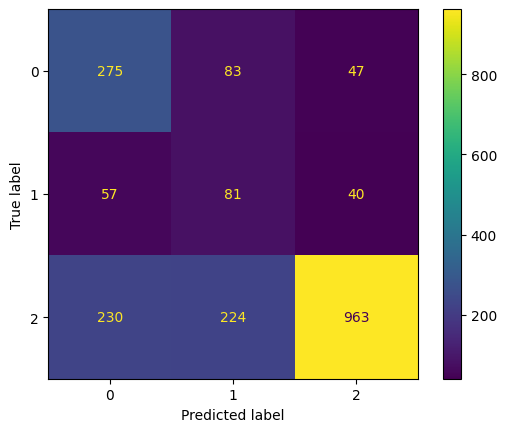

In [105]:
# Creating a confusion matrix and it seems that predicting on class 0 and 1 are not as good as class 2
ConfusionMatrixDisplay.from_estimator(xgbclass, X_test_vect, y_test)

In [106]:
# Predicting and creating a classification report on model
# Precision score seems good but the logistic regression is still the best
xgbclass_predict1 = xgbclass.predict(X_test_vect)
print(classification_report(y_test, xgbclass_predict1))

              precision    recall  f1-score   support

           0       0.49      0.68      0.57       405
           1       0.21      0.46      0.29       178
           2       0.92      0.68      0.78      1417

    accuracy                           0.66      2000
   macro avg       0.54      0.60      0.55      2000
weighted avg       0.77      0.66      0.69      2000



In [ ]:
# Fitting a pipeline for random forest model with SMOTE
modelrand = [('rfc', RandomForestClassifier())]
scrand = StackingClassifier(estimators=modelrand, final_estimator=None)
plrand = Pipeline([('smote', SMOTE()), ('modelforest', scrand)])
plrand.fit(X_train_tf, y_train)

Pipeline(steps=[('smote', SMOTE()),
                ('modelforest',
                 StackingClassifier(estimators=[('rfc',
                                                 RandomForestClassifier())]))])

In [ ]:
# Getting the scores of the train and test
# There is overfitting and seems like SMOTE is not helping with that
print(plrand.score(X_test_tf, y_test))
print(plrand.score(X_train_tf, y_train))

0.7625
0.988125


In [ ]:
# Adding hyperparameters to random forest to fix class imbalance and get a better score
pl_grid_rand1 = {'modelforest__rfc__n_estimators': [50, 100, 150, 200],
          'modelforest__rfc__max_depth': [2, 3, 4, 5, 6, 7]}

pl_search_rand1 = GridSearchCV(estimator=plrand,
                         param_grid=pl_grid_rand1,
                         scoring='roc_auc',
                         cv=5,
                         n_jobs=-1)
pl_search_rand1.fit(X_train_tf, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote', SMOTE()),
                                       ('modelforest',
                                        StackingClassifier(estimators=[('rfc',
                                                                        RandomForestClassifier())]))]),
             n_jobs=-1,
             param_grid={'modelforest__rfc__max_depth': [2, 3, 4, 5, 6, 7],
                         'modelforest__rfc__n_estimators': [50, 100, 150, 200]},
             scoring='roc_auc')

In [ ]:
# best params are max depth at 2 and number of estimators at 50
display(pl_search_rand1.best_params_)

{'modelforest__rfc__max_depth': 2, 'modelforest__rfc__n_estimators': 50}

In [ ]:
# Adding the hyperparamters to the random forest
rforest = RandomForestClassifier(n_estimators=50, max_depth=2)
rforest.fit(X_train_vect, y_train_resampled)

RandomForestClassifier(max_depth=2, n_estimators=50)

In [ ]:
# Getting the scores of test and train
# fixed class imbalance
print(rforest.score(X_test_vect, y_test))
print(rforest.score(X_train_vect, y_train_resampled))

0.6225
0.61657848324515


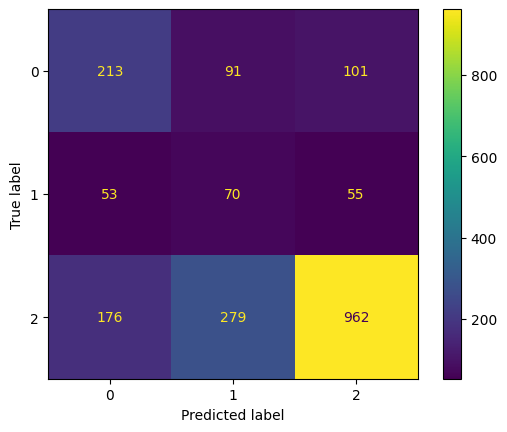

In [ ]:
# Creating confusion matrix
ConfusionMatrixDisplay.from_estimator(rforest, X_test_vect, y_test)

In [ ]:
# Predicting and creating a classification report from the model
# Precision score is 72 but is still not as good as the logistic regression model
rforest_predict1 = rforest.predict(X_test_vect)
print(classification_report(y_test, rforest_predict1))

              precision    recall  f1-score   support

           0       0.48      0.53      0.50       405
           1       0.16      0.39      0.23       178
           2       0.86      0.68      0.76      1417

    accuracy                           0.62      2000
   macro avg       0.50      0.53      0.50      2000
weighted avg       0.72      0.62      0.66      2000

